# Deep learning models for GTSRB dataset

### Imports

In [26]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

from collections import Counter

# plotting
import matplotlib.pyplot as plt

# to display confusion matrix
import seaborn as sn
import pandas as pd

BATCH_SIZE = 32
IMAGE_SIZE = 32

Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Auxiliary functions for display purposes only

In [3]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img2= decode_img(img)
  return img2, label


def show_batch(image_batch, label_batch):

    cols = 8

    rows = int(BATCH_SIZE / cols)
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols


    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):

        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()
    plt.show()


def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


def show_accuracies():
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()


def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):

    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*2*num_cols, 2*2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])


  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(43))
  plt.xticks(fontsize=5)
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*2*num_cols, 2*2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()


def convert_to_png(data_path, convert=True):
    if convert:
        for i in range (NUM_CLASSES):
            image_path = os.path.join(data_path, format(i, '05d')) #Datasets/images/00001
            files = os.listdir(image_path) #['00001_00000.ppm', ...]

            for file in files:
                try:
                    image = Image.open(os.path.join(image_path,file))
                    image.save(f"{image_path}/{file.split('.')[0]}.png")
                except:
                    pass
        print(f'Finished converting all files in {data_path} into png files.')
    else:
        print(f'Dataset: {data_path} remains unchanged.')


def show_confusion_matrix(model, dataset):

    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)

        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]

    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

    df_cm = pd.DataFrame(conf_mat.numpy(), range(43), range(43))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='d') # font size

    plt.show()

    res_correct = Counter()
    res_incorrect = Counter()
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):

        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))



def process_dataset(dataset, data_size):
    data = dataset
    data = data.cache()
    data = data.shuffle(buffer_size = data_size)
    data = data.prefetch(buffer_size=AUTOTUNE)

    return data

### Default values

Subject to change

In [4]:
DIMENTION = (IMAGE_SIZE, IMAGE_SIZE)
N_CHANNELS = 3
KERNEL_SIZE = (5,5)
N_EPOCHS = 25

TRAIN_ONLINE = True

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Local Settings

set the paths to the image data and where the model and logs will be saved.

In [5]:
data_path = '../Datasets/train_images'
test_path = '../Datasets/test_images'
call_path = '../Callbacks/Version3'

WEIGHT_FILE_PREFIX = '../Results/model3.hdf5'

classNames = np.array(os.listdir(data_path))

N_CLASSES = len(classNames)

### Convert data into png

In some functions of **tf.keras.preprocessing** the format *.ppm* isn't supported by them. That beeing said, it was developed a function capable of converting every single *.ppm* file into a *.png* readable by the preprocessing functions.

In addition, this function has an option that enables and disables the conversion of the images, "Y" to enable and "N" to disable.

In [6]:
convert_to_png(data_path, False)

convert_to_png(test_path, False)

Dataset: /content/Datasets/train_images remains unchanged.
Dataset: /content/Datasets/test_images remains unchanged.


### Load data

In [7]:
datasetV1 = keras.preprocessing.image_dataset_from_directory(
    f'{data_path}',
    batch_size=32,
    label_mode='categorical',
    image_size=DIMENTION,
    shuffle=True
)

normalize = keras.layers.experimental.preprocessing.Rescaling(1.0/255)

datasetV1 = datasetV1.map(lambda x,y: (normalize(x), y))

Found 39209 files belonging to 43 classes.


### Print some data and compute dataset length

In [8]:
t = next(iter(datasetV1))
print(t[0].shape, t[1].shape)

# dataset_length = datasetV1.cardinality().numpy()

dataset_length = 39209 # manual set of length

print(f'\nTotal images: {dataset_length}')

(32, 32, 32, 3) (32, 43)

Total images: 39209


### Prepare the test set

In [9]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    f'{test_path}',
    image_size=DIMENTION,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

testset = testset.map(lambda x, y: (normalize(x), y))

Found 12630 files belonging to 43 classes.


### Show the first batch

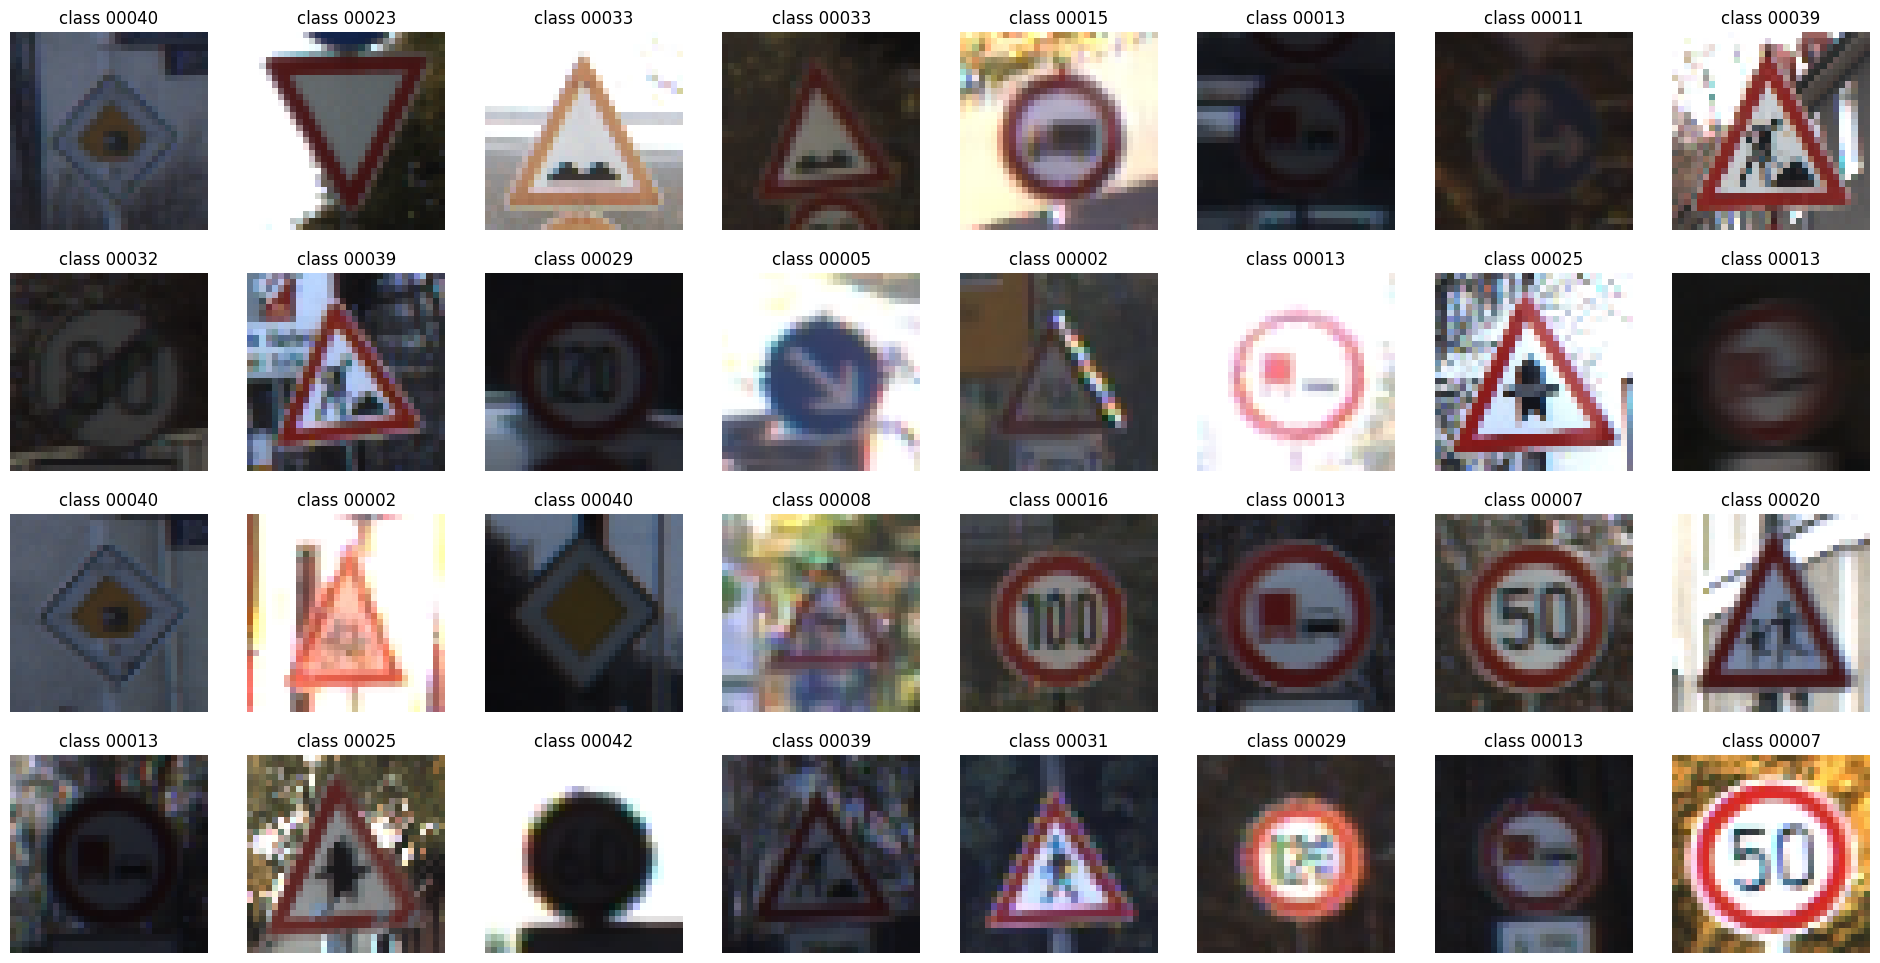

<Figure size 640x480 with 0 Axes>

In [10]:
image_batch, label_batch = next(iter(datasetV1))
show_batch(image_batch, label_batch.numpy())

### Preping the data and creating a Validation Set

In [11]:
train_size = int(0.8 * dataset_length/BATCH_SIZE)
val_size = int(0.2 * dataset_length/BATCH_SIZE)

train_dataset = datasetV1.take(train_size)
val_dataset = datasetV1.skip(train_size)

val_len = val_dataset.cardinality().numpy()
train_len = train_dataset.cardinality().numpy()

print(f'Train_Set length: {train_len}')
print(f'Valid_Set length: {val_len}')

Train_Set length: 980
Valid_Set length: 246


In [12]:
val_dataset = process_dataset(val_dataset, val_len)

### Massive Data augmentation

In [13]:
import tensorflow_addons as tfa

def process_brightness(image, label):

    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):

    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):

    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):

    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):

    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[32,c,c,3])
    img = tf.image.resize(img ,size= [32,32])
    return img, label

In [14]:

data_agumented = train_dataset

# color ops
data_agumented = data_agumented.map(process_brightness)
data_agumented = data_agumented.concatenate(train_dataset.map(process_contrast))
data_agumented = data_agumented.concatenate(train_dataset.map(process_hue))
data_agumented = data_agumented.concatenate(train_dataset.map(process_saturation))

#geometry ops
data_agumented = data_agumented.concatenate(train_dataset.map(process_rotate))
data_agumented = data_agumented.concatenate(train_dataset.map(process_shear))
data_agumented = data_agumented.concatenate(train_dataset.map(process_translate))
data_agumented = data_agumented.concatenate(train_dataset.map(process_crop))

data_agumented = data_agumented.cache()
data_agumented = data_agumented.shuffle(buffer_size = 81600)
data_agumented = data_agumented.prefetch(buffer_size = AUTOTUNE)

print(data_agumented.cardinality().numpy())


7840


### Show Images after data augmentation

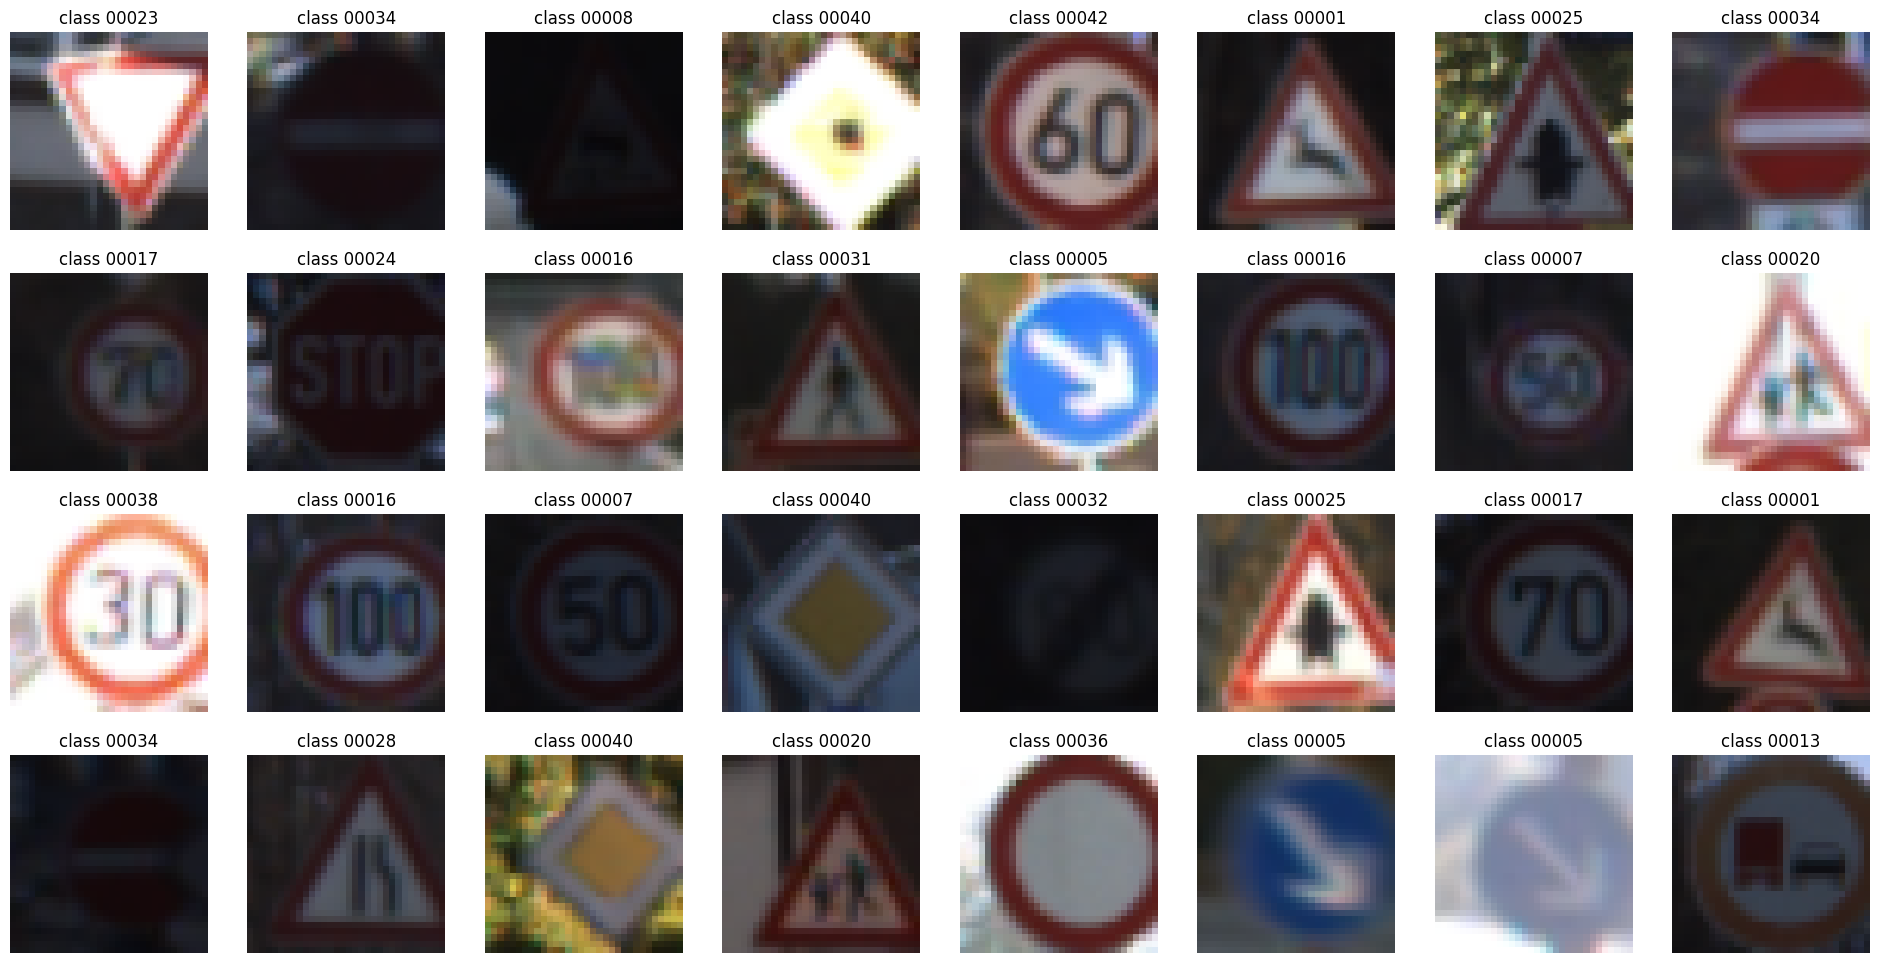

<Figure size 640x480 with 0 Axes>

In [15]:
image_batch, label_batch = next(iter(data_agumented))
show_batch(image_batch, label_batch.numpy())

### Developed Models

In [16]:
def model_0(classCount, imgSize, channels):
    model = Sequential()

    model.add(Input(shape=(imgSize, imgSize, channels)))

    model.add(Conv2D(64, KERNEL_SIZE, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, KERNEL_SIZE) )
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(classCount, activation='softmax'))


    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



def model_1():
    model = Sequential()

    model.add(Conv2D(128, KERNEL_SIZE, padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(196,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(256,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dense(384))
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dropout(0.5))


    model.add(Dense(43, activation='softmax'))

    apt = Adam(learning_rate=0.0001)
    model.compile(optimizer=apt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def model_2():
    model = Sequential()

    model.add(Conv2D(128, KERNEL_SIZE, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(196,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(256,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(512,KERNEL_SIZE))
    model.add(Conv2D(512,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dense(384))
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dropout(0.5))


    model.add(Dense(N_CLASSES, activation='softmax'))

    apt = Adam(learning_rate=0.0001)
    model.compile(optimizer=apt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def create_model():

    modelLogits = Sequential()

    modelLogits.add(Conv2D(128, KERNEL_SIZE, padding='same', input_shape=(32, 32, 3)))
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5))

    modelLogits.add(Conv2D(196,KERNEL_SIZE))
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5))

    modelLogits.add(Conv2D(256,KERNEL_SIZE))
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    modelLogits.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    modelLogits.add(Dropout(0.5))

    modelLogits.add(Flatten())
    modelLogits.add(LeakyReLU(alpha=0.00))
    modelLogits.add(Dense(384))
    modelLogits.add(LeakyReLU(alpha=0.00))
    modelLogits.add(Dropout(0.5))

    modelLogits.add(Dense(43))

    output = Activation('softmax')(modelLogits.output)

    model = tf.keras.Model(modelLogits.inputs, output)

    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model, modelLogits

N_MODELS = 1

def train_models(train, val,file_path_prefix):

    models = []
    histories = []

    for i in range(N_MODELS):

        model, modelL = create_model()

        if TRAIN_ONLINE:
            callbacks = prepare_callbacks(f'{file_path_prefix}_{i:02}/cp.ckpt')

            hist = model.fit(train,
                            epochs=10,
                            validation_data = val,
                            callbacks = callbacks)

        models.append([model, modelL])
        histories.append(hist)

    return models,histories

#### Callback definition

In [17]:
def prepare_callbacks(file_path):

    pointer = ModelCheckpoint(filepath=file_path, monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True)
    stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=200, verbose=1)
    reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=200, min_lr=0.0)

    return [pointer, stopper, reduceLr]

### Model Training

In [18]:
models_V3, histories_V3 = train_models(data_agumented, val_dataset, f'{call_path}/callbackV3')

Epoch 1/10
7835/7840 [============================>.] - ETA: 0s - loss: 1.5506 - accuracy: 0.5675
Epoch 1: val_accuracy improved from -inf to 0.98751, saving model to /content/Callbacks/Version3/callbackV3_00/cp.ckpt
7840/7840 [==============================] - 60s 6ms/step - loss: 1.5500 - accuracy: 0.5676 - val_loss: 0.0586 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 2/10
7838/7840 [============================>.] - ETA: 0s - loss: 0.2322 - accuracy: 0.9315
Epoch 2: val_accuracy improved from 0.98751 to 0.99745, saving model to /content/Callbacks/Version3/callbackV3_00/cp.ckpt
7840/7840 [==============================] - 45s 6ms/step - loss: 0.2322 - accuracy: 0.9315 - val_loss: 0.0113 - val_accuracy: 0.9975 - lr: 1.0000e-04
Epoch 3/10
7838/7840 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9642
Epoch 3: val_accuracy improved from 0.99745 to 0.99936, saving model to /content/Callbacks/Version3/callbackV3_00/cp.ckpt
7840/7840 [==============================

### Show accuracy and loss history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


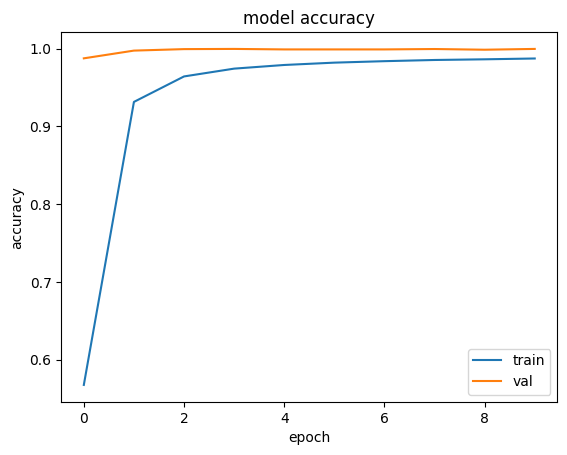

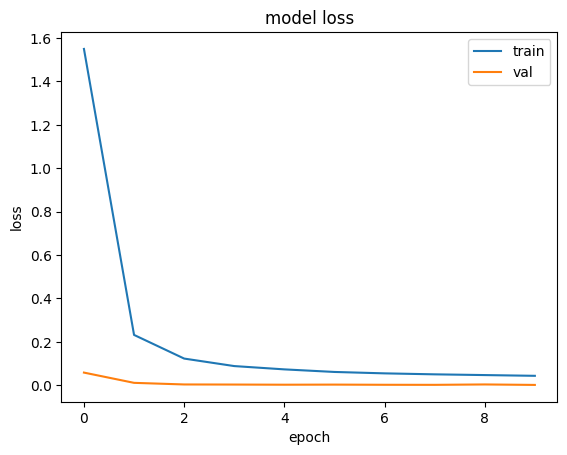

In [19]:
for i in range (N_MODELS):
    show_history(histories_V3[i])

### Evaluate the model

In [20]:
def evaluate_models(models):

    accuracy = 0

    for i in range(N_MODELS):

        eval = models[i][0].evaluate(testset, verbose = 2)
        accuracy += eval[1]

    print(f'\nAverage accuracy: {(accuracy/N_MODELS)*100:.3f}')


evaluate_models(models_V3)

395/395 - 1s - loss: 0.0289 - accuracy: 0.9922 - 1s/epoch - 3ms/step

Average accuracy: 99.224


### Evaluating on a single image

In [21]:
from PIL import Image

img = Image.open(f'{test_path}/00002/00034.png')
img = img.resize(DIMENTION)

numpy_image = np.asarray(img)
numpy_image = np.expand_dims(numpy_image, axis=0)

for i in range(N_MODELS):
    in_pred = models_V3[i][0].predict([numpy_image])

print(in_pred)

1/1 [==============================] - 0s 241ms/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [22]:
data, = testset.take(1)

print(data[1][:5])

for i in range(N_MODELS):
    in_pred = models_V3[i][0].predict(np.expand_dims(data[0][0], axis=0))

print(in_pred)

tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(5, 43), dtype=float32)
1/1 [==============================] - 0s 100ms/step
[[1.1602507e-37 1.1532895e-26 3.1888800e-19 1.0000000e+00 7.9422548e-37
  1.8999719e-13 1.8684271e-27 3.6528366e-33 4.7843920e-34 7.8664616e-27
  2.5606407e-31 6.1984935e-38 0.0000000e+00 2.9564649e-33 0.0000000e+00
  4.0242101e-33 8.

### Check model performance

1/1 [==============================] - 0s 21ms/step


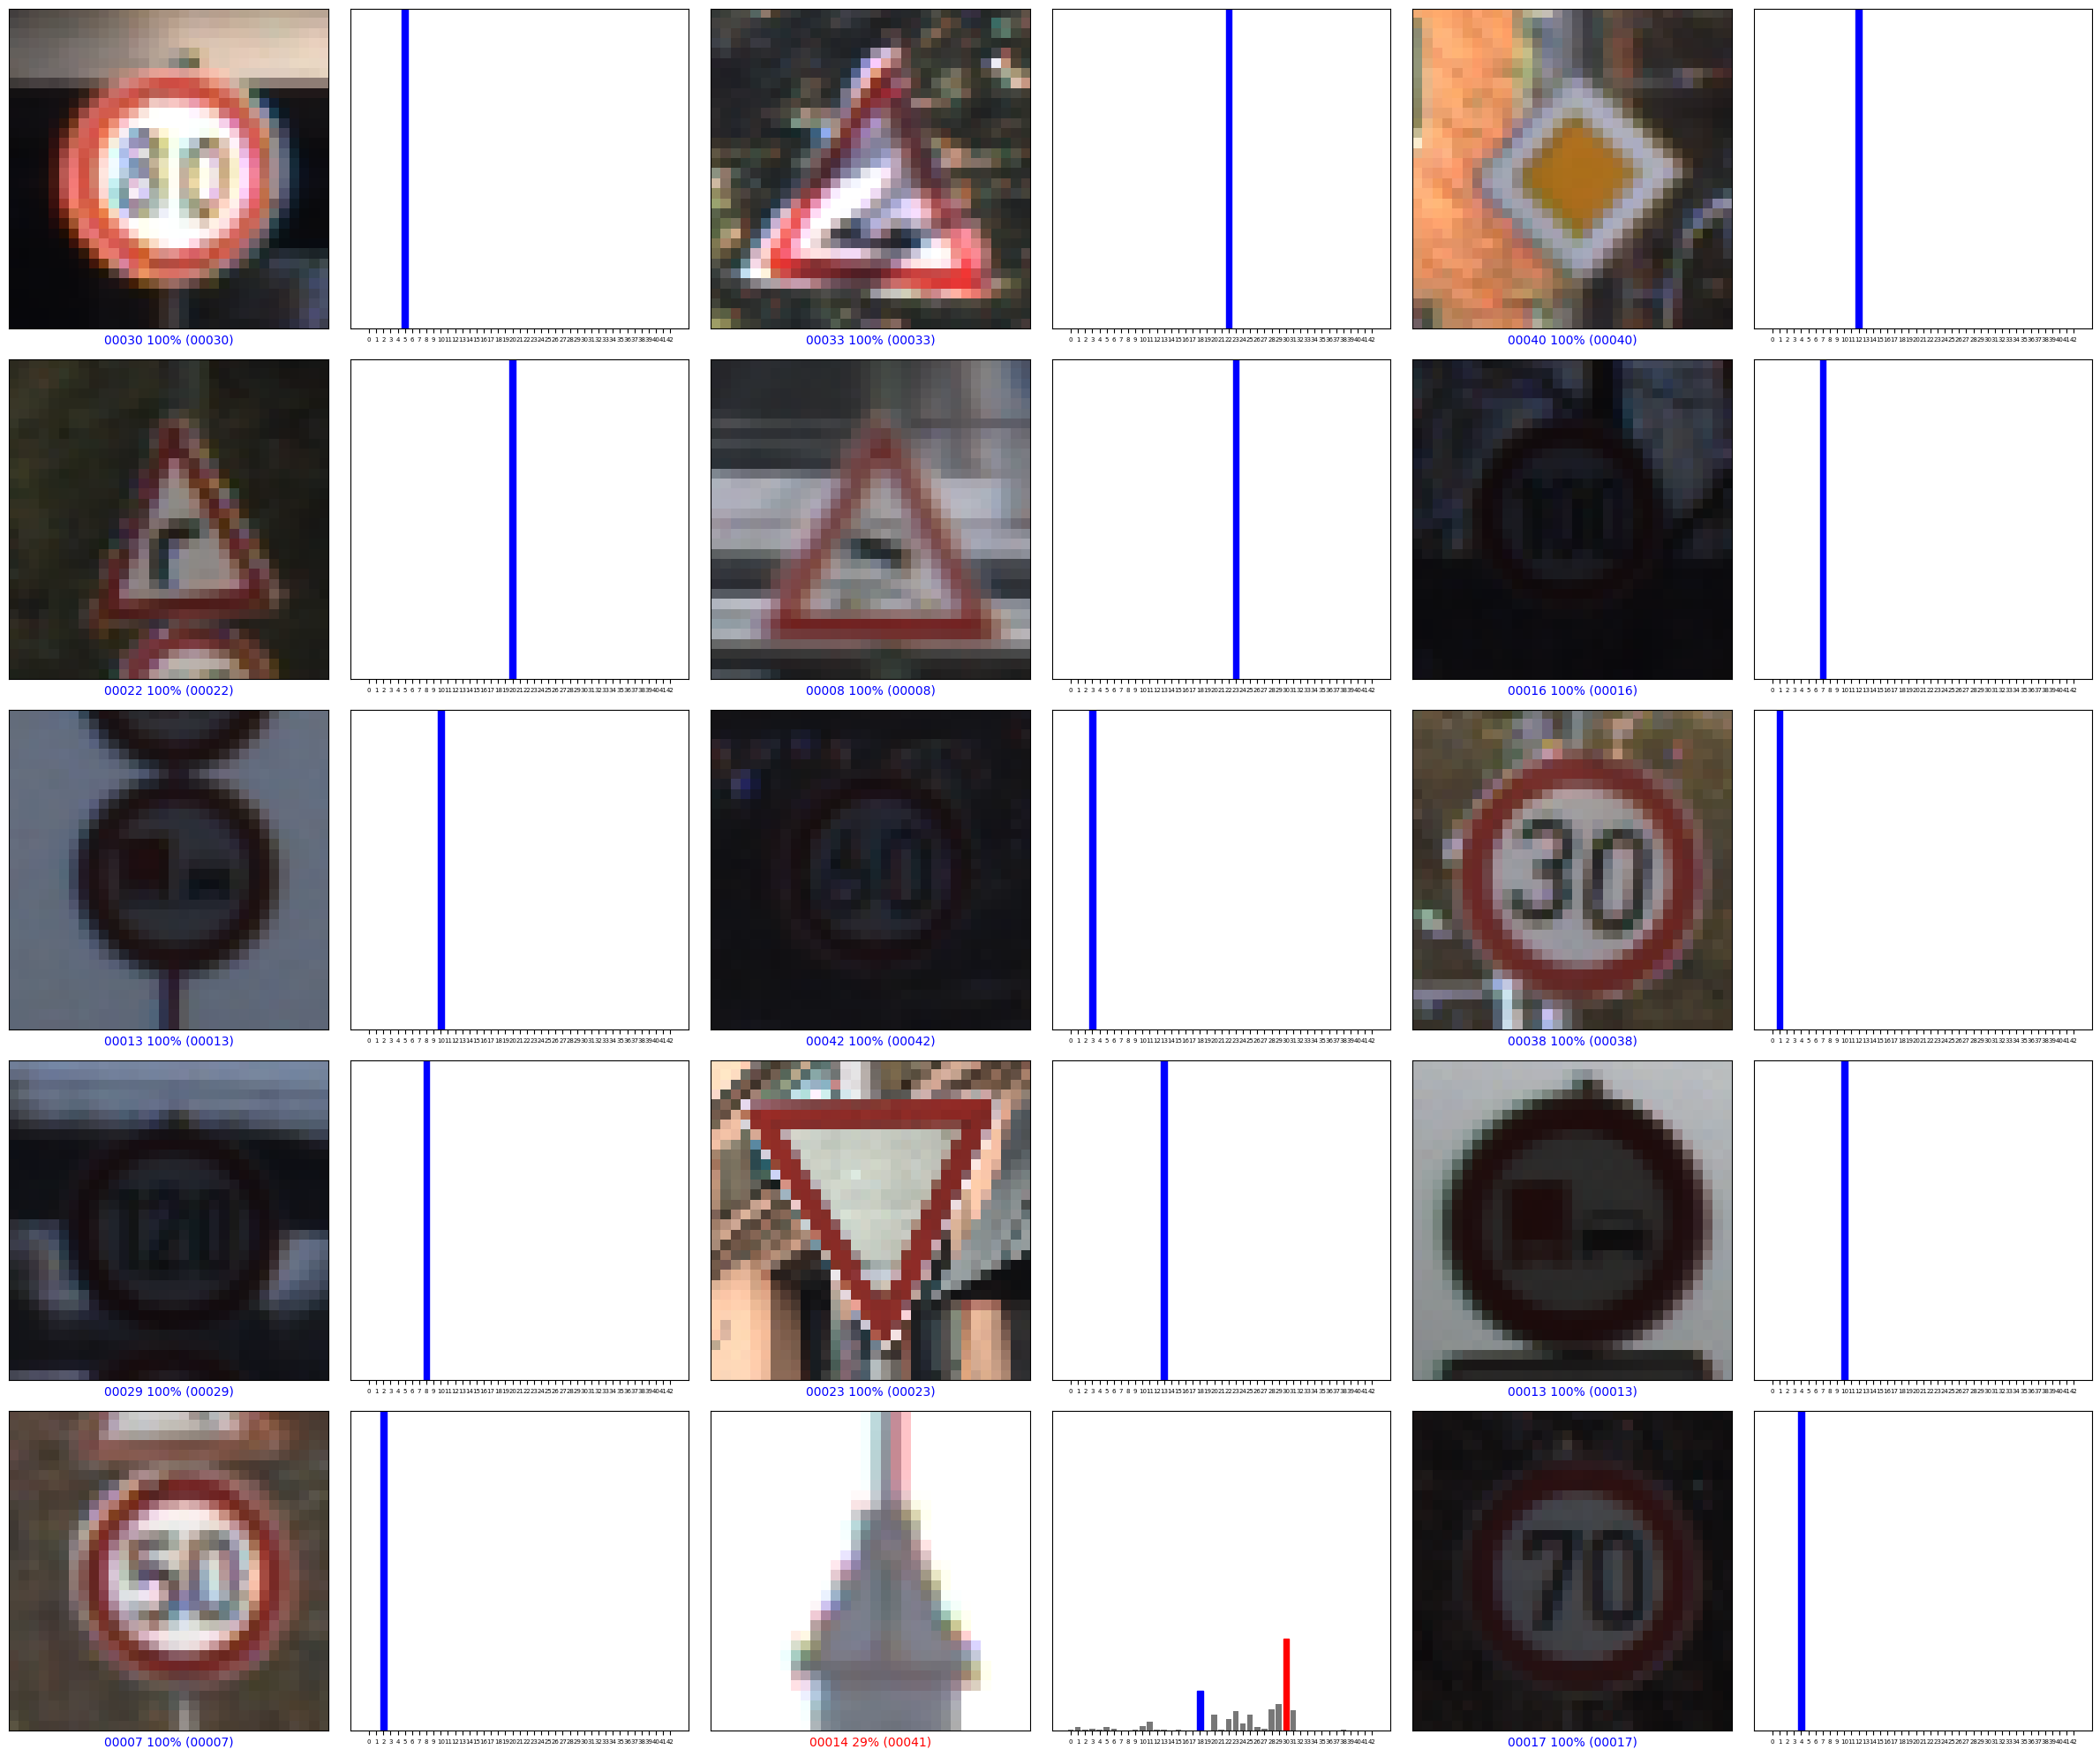

In [23]:
numpy_labels = []
numpy_images = []
pred = []

for i in range(N_MODELS):
    for images, labels in testset.take(-1):
        numpy_images.extend(images.numpy())
        numpy_labels.extend(labels.numpy())
        pred.extend(models_V3[i][0].predict(images.numpy()))


plot_predictions(pred, numpy_labels, numpy_images)

1/1 [==============================] - 0s 22ms/step


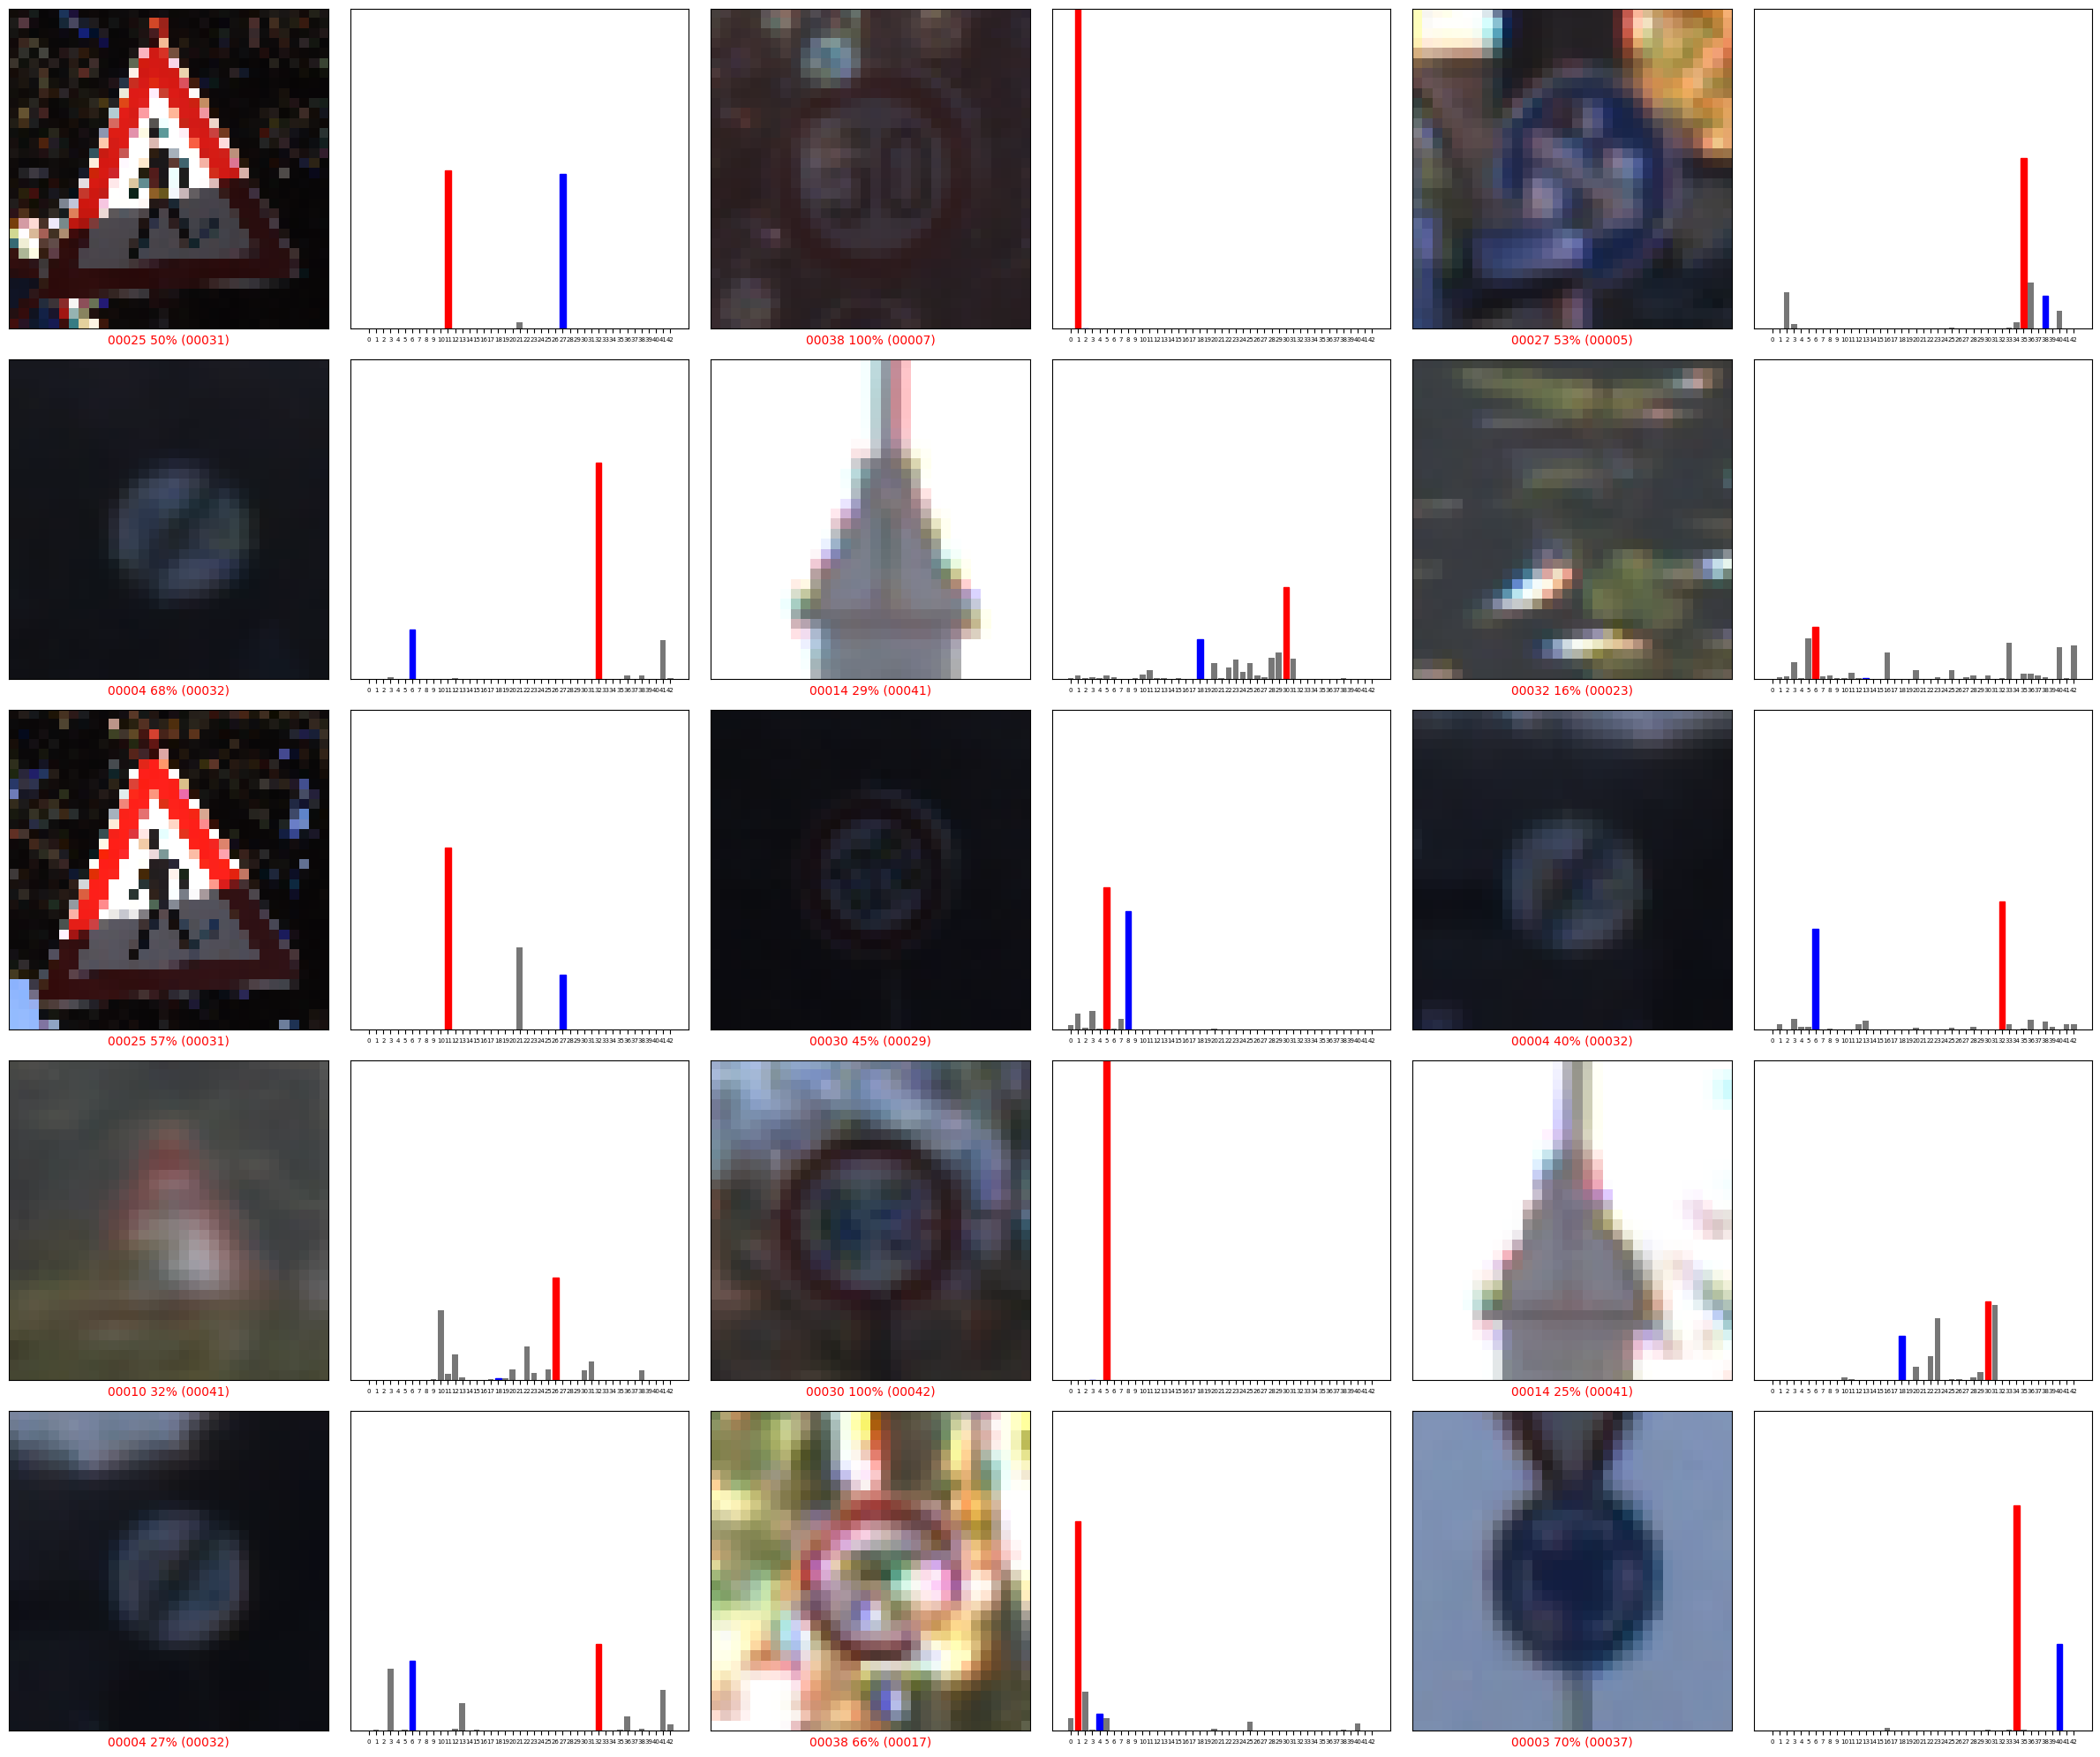

In [24]:
numpy_labels = []
numpy_images = []
pred = []

for i in range(N_MODELS):
    for images, labels in testset.take(-1):
        numpy_images.extend(images.numpy())
        numpy_labels.extend(labels.numpy())
        pred.extend(models_V3[i][0].predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images)


### Confusion Matrix

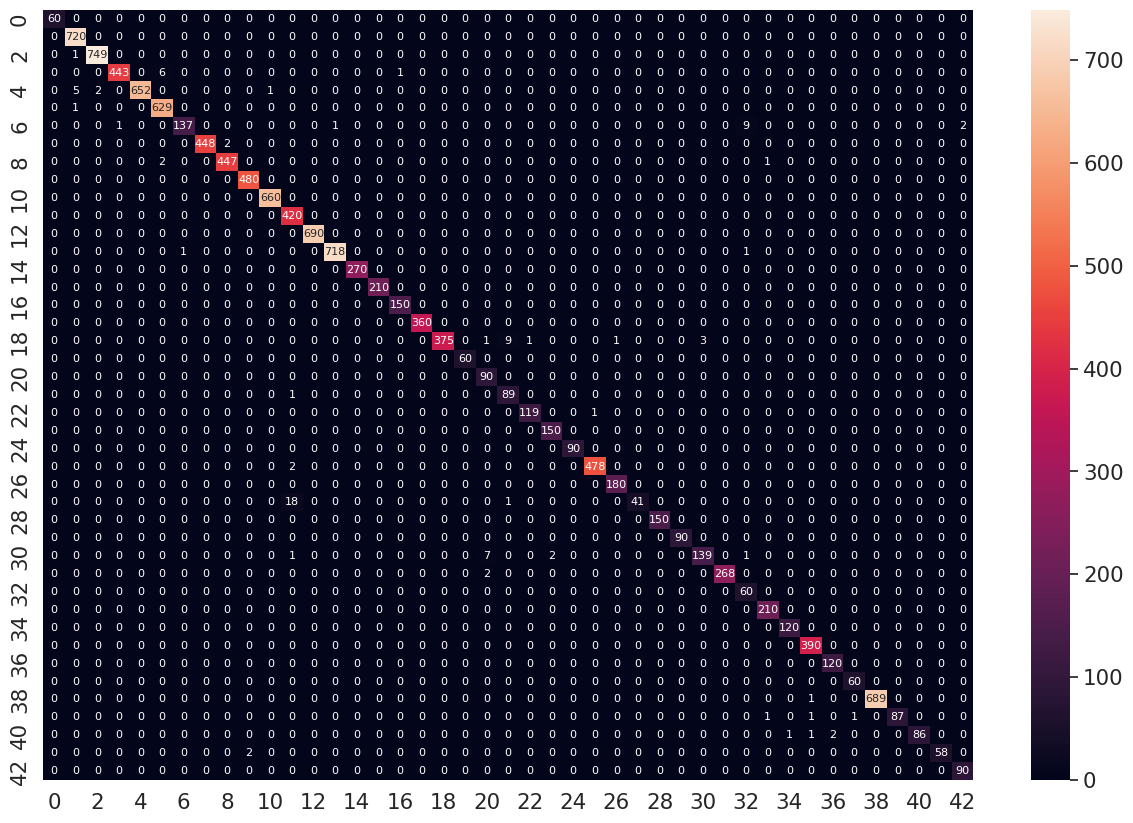

class:  0  total images:  60  % correct:  1.0
class:  1  total images:  720  % correct:  1.0
class:  2  total images:  750  % correct:  0.9986666666666667
class:  3  total images:  450  % correct:  0.9844444444444445
class:  4  total images:  660  % correct:  0.9878787878787879
class:  5  total images:  630  % correct:  0.9984126984126984
class:  6  total images:  150  % correct:  0.9133333333333333
class:  7  total images:  450  % correct:  0.9955555555555555
class:  8  total images:  450  % correct:  0.9933333333333333
class:  9  total images:  480  % correct:  1.0
class:  10  total images:  660  % correct:  1.0
class:  11  total images:  420  % correct:  1.0
class:  12  total images:  690  % correct:  1.0
class:  13  total images:  720  % correct:  0.9972222222222222
class:  14  total images:  270  % correct:  1.0
class:  15  total images:  210  % correct:  1.0
class:  16  total images:  150  % correct:  1.0
class:  17  total images:  360  % correct:  1.0
class:  18  total images:  

In [25]:
for i in range(N_MODELS):
    show_confusion_matrix(models_V3[i][0], testset)